# Comparativa de clasificadores para precio

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2


# Leemos el dataset

In [2]:
df = pd.read_csv('../data/train.csv').dropna(
    subset=['precio','metroscubiertos']
)

## Agregando frecuencia como feature

Nueva feature: frecuencia promedio de titulo y descripcion.
    
Intuicion: Inmuebles con titulos / descripciones con frecuencia promedio
similar pueden llegar a tener caracteristicas similares, por ejemplo el
precio.

In [3]:
%%time
import wordcloud_features as wf
desc_wc, titles_wc = wf.add_frequency_features(df)

CPU times: user 1min 20s, sys: 601 ms, total: 1min 20s
Wall time: 1min 21s


## Agregando feature cheto

In [4]:
df['cheto'] = (
    (df['gimnasio']==1) &
    (df['piscina']==1) &
    (df['usosmultiples']==1) & 
    (df['garages']!=0)
)

df['chetocidad'] = (
    df['gimnasio'] +
    df['piscina'] +
    df['usosmultiples'] +
    df['garages']
)


Text(0.5, 1.0, 'Distribucion de precios por grado de chetocidad')

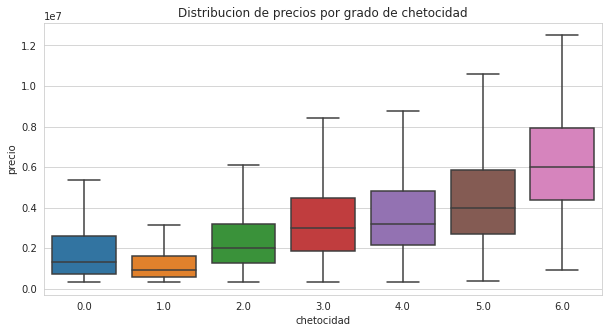

In [14]:
plt.subplots(1, 1, figsize=(10, 5))
sns.set_style("whitegrid")
ax = sns.boxplot(data=df, x='chetocidad', y='precio', showfliers=False)
ax.set_title("Distribucion de precios por grado de chetocidad")

## Corriendo los clasificadores

In [7]:
import metnum
import wrappers
import pandas as pd
import stepwise_selectors as ss

from cross_validation import cross_validate
from tqdm import tqdm

clfs = [
    ## Segmentando por provincia
    # Control
    {
        "segment": "provincia", "explains": "precio", "kind":"projection",
        "clf": wrappers.ProjectionRegression(
                features=["metroscubiertos"],
                explain='precio',
                func_segment = lambda df: wrappers.segment_by_col(df, 'provincia'),
        ),
    },
    # Usando frecuencias de titulo y desc
    {
        "segment": "provincia", "explains": "precio", "kind":"projection con freqs",
        "clf": wrappers.ProjectionRegression(
                features=['metroscubiertos', 'avg_freq_title', 'avg_freq_desc'],
                explain='precio',
                func_segment = lambda df: wrappers.segment_by_col(df, 'provincia'),
        ),
    },
    # Sacados de stepwise
    # func_builder(features, explain, seg_col)
    {
        "segment": "provincia", "explains": "precio", "kind":"quadratic",
        "clf": ss.fb_poly_quadratic_seg_by_col(
            fs=['metroscubiertos', 'metrostotales'],
            e="precio",
            seg_col="provincia",
        ),
    },
    {
        "segment": "provincia", "explains": "precio", "kind":"linear",
        "clf": ss.fb_poly_linear_seg_by_col(
            fs=['metroscubiertos', 'metrostotales', 'banos', 'habitaciones', 'garages'],
            e='precio',
            seg_col='provincia',
        ),
    },
    {
        "segment": "provincia", "explains": "precio", "kind":"degree 4",
        "clf": ss.func_builder_polynomial_d4_sbc(
            fs=['metroscubiertos', 'metrostotales', 'habitaciones'],
            e='precio',
            seg_col='provincia',
        ),
    },
    ## Segmentando por ciudad
    {
        "segment": "ciudad", "explains": "precio", "kind":"projection",
        "clf": wrappers.ProjectionRegression(
                features=["metroscubiertos"],
                explain='precio',
                func_segment = lambda df: wrappers.segment_by_col(df, 'ciudad'),
        ),
    },
    {
        "segment": "ciudad", "explains": "precio", "kind":"projection con freqs",
        "clf": wrappers.ProjectionRegression(
                features=['metroscubiertos', 'avg_freq_title', 'avg_freq_desc'],
                explain='precio',
                func_segment = lambda df: wrappers.segment_by_col(df, 'ciudad'),
        ),
    },
    {
        "segment": "ciudad", "explains": "precio", "kind":"quadratic",
        "clf": ss.fb_poly_quadratic_seg_by_col(
            fs=['metroscubiertos', 'metrostotales'],
            e="precio",
            seg_col="ciudad",
        ),
    },
    {
        "segment": "ciudad", "explains": "precio", "kind":"linear",
        "clf": ss.fb_poly_linear_seg_by_col(
            fs=['metroscubiertos', 'metrostotales', 'banos', 'habitaciones', 'garages'],
            e='precio',
            seg_col='ciudad',
        ),
    },
    {
        "segment": "ciudad", "explains": "precio", "kind":"degree 4",
        "clf": ss.func_builder_polynomial_d4_sbc(
            fs=['metroscubiertos', 'metrostotales', 'habitaciones'],
            e='precio',
            seg_col='ciudad',
        ),
    },
    ## Antiguedad
    {
        "segment": "antiguedad", "explains": "precio", "kind":"projection",
        "clf": wrappers.ProjectionRegression(
                features=["metroscubiertos"],
                explain='precio',
                func_segment = lambda df: wrappers.segment_by_col(df, 'antiguedad'),
        ),
    },
    {
        "segment": "antiguedad", "explains": "precio", "kind":"projection con freqs",
        "clf": wrappers.ProjectionRegression(
                features=['metroscubiertos', 'avg_freq_title', 'avg_freq_desc'],
                explain='precio',
                func_segment = lambda df: wrappers.segment_by_col(df, 'antiguedad'),
        ),
    },
    {
        "segment": "antiguedad", "explains": "precio", "kind":"quadratic",
        "clf": ss.fb_poly_quadratic_seg_by_col(
            fs=['metroscubiertos', 'metrostotales'],
            e="precio",
            seg_col="antiguedad",
        ),
    },
    {
        "segment": "antiguedad", "explains": "precio", "kind":"linear",
        "clf": ss.fb_poly_linear_seg_by_col(
            fs=['metroscubiertos', 'metrostotales', 'banos', 'habitaciones', 'garages'],
            e='precio',
            seg_col='antiguedad',
        ),
    },
    {
        "segment": "antiguedad", "explains": "precio", "kind":"degree 4",
        "clf": ss.func_builder_polynomial_d4_sbc(
            fs=['metroscubiertos', 'metrostotales', 'habitaciones'],
            e='precio',
            seg_col='antiguedad',
        ),
    },
    ## Sin segmentar
    {
        "segment": "None", "explains": "precio", "kind":"projection",
        "clf": wrappers.ProjectionRegression(
                features=["metroscubiertos"],
                explain='precio',
        ),
    },
    {
        "segment": "None", "explains": "precio", "kind":"projection con freqs",
        "clf": wrappers.ProjectionRegression(
                features=['metroscubiertos', 'avg_freq_title', 'avg_freq_desc'],
                explain='precio',
        ),
    },
    {
        "segment": "None", "explains": "precio", "kind":"quadratic",
        "clf": wrappers.PolynomialRegressor(
            degree=2,
            features=['metroscubiertos', 'metrostotales'],
            explain="precio",
        ),
    },
    {
        "segment": "None", "explains": "precio", "kind":"linear",
        "clf": wrappers.PolynomialRegressor(
            degree=1,
            features=['metroscubiertos', 'metrostotales', 'banos', 'habitaciones', 'garages'],
            explain='precio',
        ),
    },
    {
        "segment": "None", "explains": "precio", "kind":"degree 4",
        "clf": wrappers.PolynomialRegressor(
            degree=4,
            features=['metroscubiertos', 'metrostotales', 'habitaciones'],
            explain='precio',
        ),
    },
    # seg chetocidad
    {
        "segment": "chetocidad", "explains": "precio", "kind":"projection",
        "clf": wrappers.ProjectionRegression(
                features=["metroscubiertos"],
                explain='precio',
                func_segment = lambda df: wrappers.segment_by_col(df, 'chetocidad'),
        ),
    },
    {
        "segment": "chetocidad", "explains": "precio", "kind":"projection con freqs",
        "clf": wrappers.ProjectionRegression(
                features=['metroscubiertos', 'avg_freq_title', 'avg_freq_desc'],
                explain='precio',
                func_segment = lambda df: wrappers.segment_by_col(df, 'chetocidad'),
        ),
    },
    {
        "segment": "chetocidad", "explains": "precio", "kind":"quadratic",
        "clf": ss.fb_poly_quadratic_seg_by_col(
            fs=['metroscubiertos', 'metrostotales'],
            e="precio",
            seg_col="chetocidad",
        ),
    },
    {
        "segment": "chetocidad", "explains": "precio", "kind":"linear",
        "clf": ss.fb_poly_linear_seg_by_col(
            fs=['metroscubiertos', 'metrostotales', 'banos', 'habitaciones', 'garages'],
            e='precio',
            seg_col='chetocidad',
        ),
    },
    {
        "segment": "chetocidad", "explains": "precio", "kind":"degree 4",
        "clf": ss.func_builder_polynomial_d4_sbc(
            fs=['metroscubiertos', 'metrostotales', 'habitaciones'],
            e='precio',
            seg_col='chetocidad',
        ),
    },
]

K = 4
DEBUG = False
SCORINGS = ["r2", "rmse", "rmsle"]

rows = []
dfs = []
for entry in tqdm(clfs, "classifiers"):
    clf = entry["clf"]
    kind = entry["kind"]
    explains = entry["explains"]
    segment = entry["segment"]
    name = f"{kind}-for_{explains}_by_{segment}"

    scores, pred = cross_validate(clf, clf.dropna(df), SCORINGS, K, DEBUG)
    # scores es un dict con las keys de SCORINGS, que son las
    # mismas que las columnas del dataframe.
    rows.append({
        **{
            "kind": kind,
            "explains": explains,
            "segment_by": segment,
            "name": name,
        }, 
        **scores
    })

    pred['name'] = name
    pred['kind'] = kind
    pred['segment'] = segment
    dfs.append(pred)

print("Creating DataFrame...")
df_results = pd.DataFrame(rows, columns=["name", "kind", "explains", "segment_by", "r2", "rmse", "rmsle"])
df_pred = pd.concat(dfs)
print("Done!")

classifiers: 100%|██████████| 25/25 [03:07<00:00,  7.52s/it]


Creating DataFrame...
Done!


## Analizando los resultados

### Guardando los resultados por separado

In [18]:
df_precio = df_results[df_results["explains"]=="precio"]
df_precio.sort_values("r2", ascending=False).reset_index().to_csv("results-precio.csv", float_format="%.4f")
df_precio.sort_values("r2", ascending=False)

,name,kind,explains,segment_by,r2,rmse,rmsle
3,linear-for_precio_by_provincia,linear,precio,provincia,0.541927,1.191110e+06,0.504334
18,linear-for_precio_by_None,linear,precio,None,0.451164,1.307141e+06,0.553632
19,degree 4-for_precio_by_None,degree 4,precio,None,0.428486,1.431782e+06,0.567133
11,projection con freqs-for_precio_by_antiguedad,projection con freqs,precio,antiguedad,0.419086,1.563666e+06,0.583305
10,projection-for_precio_by_antiguedad,projection,precio,antiguedad,0.418661,1.564135e+06,0.576420
17,quadratic-for_precio_by_None,quadratic,precio,None,0.413745,1.456341e+06,0.574705
16,projection con freqs-for_precio_by_None,projection con freqs,precio,None,0.400928,1.600474e+06,0.584968
15,projection-for_precio_by_None,projection,precio,None,0.394075,1.609558e+06,0.592788
24,degree 4-for_precio_by_chetocidad,degree 4,precio,chetocidad,0.392088,1.392346e+06,0.567035
4,degree 4-for_precio_by_provincia,degree 4,precio,provincia,0.389205,1.463775e+06,0.586098


### Analisis del error

In [9]:
import numpy as np
df_pred["error"] = np.abs(df_pred["precio"] - df_pred["prediction"])

#### General

Text(0.5, 1.0, 'Distribucion de errores para prediccion de precios por tipo de clasificador')

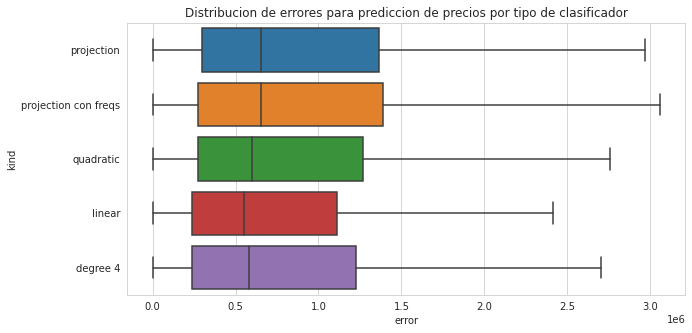

In [10]:
plt.subplots(1, 1, figsize=(10, 5))
ax = sns.boxplot(data=df_pred, x="error", y="kind", showfliers=False)
ax.set_title("Distribucion de errores para prediccion de precios por tipo de clasificador")

#### Por segmento

Text(0.5, 1.0, 'Distribucion de errores para prediccion de precios por tipo de clasificador y segmentacion')

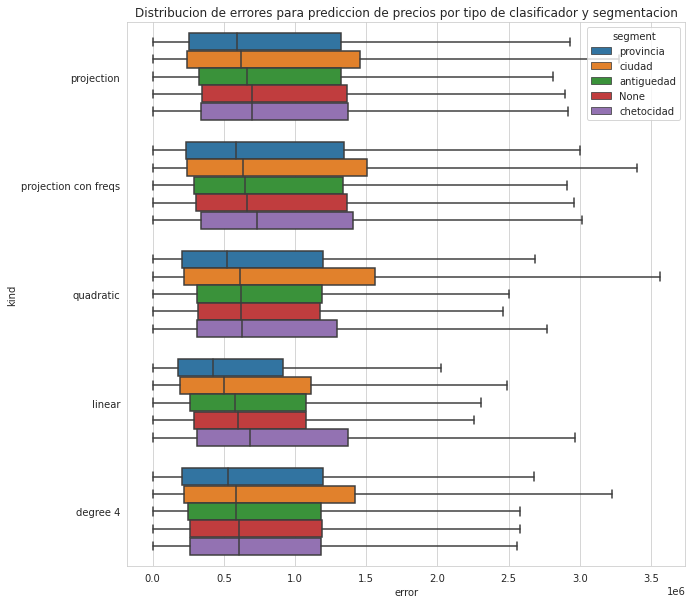

In [11]:
plt.subplots(1, 1, figsize=(10, 10))
ax = sns.boxplot(data=df_pred, x="error", y="kind", hue="segment", showfliers=False)
ax.set_title("Distribucion de errores para prediccion de precios por tipo de clasificador y segmentacion")

### Justificando elecciones de segmentacion

#### Antiguedad

Text(0.5, 1.0, 'Distribucion de precio por antiguedad')

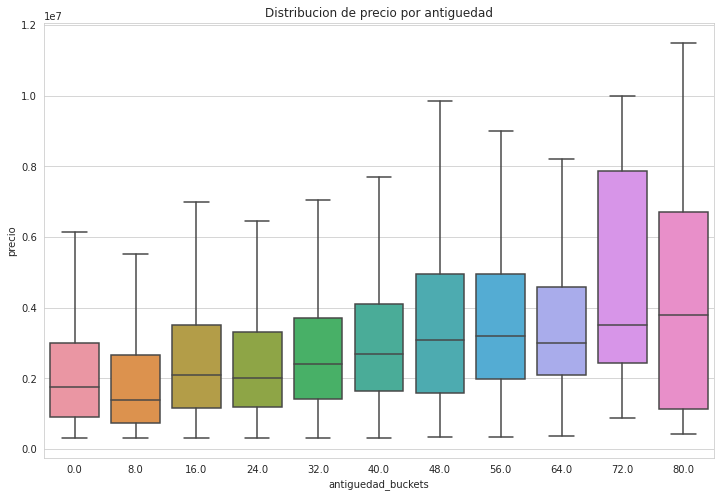

In [12]:
plt.subplots(1, 1, figsize=(12, 8))
df_pred["antiguedad_buckets"] = (df_pred["antiguedad"] // 8) * 8
ax = sns.boxplot(data=df_pred, x="antiguedad_buckets", y="precio", showfliers=False)
ax.set_title("Distribucion de precio por antiguedad")

#### Provincia

Text(0.5, 1.0, 'Distribucion de precio por provincia')

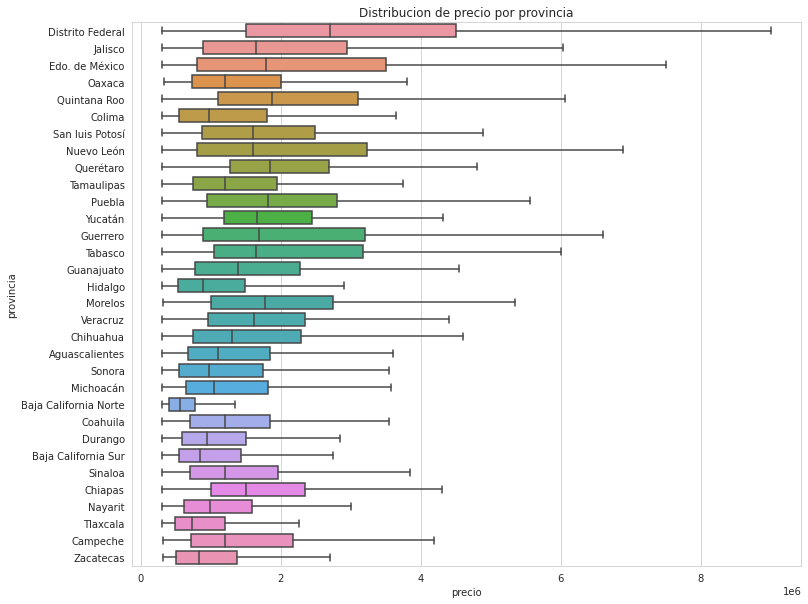

In [13]:
plt.subplots(1, 1, figsize=(12, 10))
ax = sns.boxplot(data=df_pred, x="precio", y="provincia", showfliers=False)
ax.set_title("Distribucion de precio por provincia")